In [1]:
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=1)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

In [2]:
import numpy as np

def make_score_matrix(seq_a, seq_b, match_score=1, mismatch_score=0 ):
    score_matrix = np.zeros((len(seq_a), len(seq_b)))
    for i, a in enumerate(seq_a):
        for j, b in enumerate(seq_b):
            if a == b:
                score_matrix[i,j] = match_score
            else:
                score_matrix[i,j] = mismatch_score
    return score_matrix

def align_seq(seq_a, seq_b, gap_penalty=-1):
    score_matrix = make_score_matrix(seq_a, seq_b)
    from eden.util.NeedlemanWunsh import needleman_wunsh, trace_back
    needleman_wunsh_matrix = needleman_wunsh(seq_a, seq_b, score_matrix, gap_penalty)
    nw_score = needleman_wunsh_matrix[-1,-1]
    alignment_a, alignment_b = trace_back(seq_a, seq_b, score_matrix, needleman_wunsh_matrix, gap_penalty)
    return alignment_a, alignment_b, nw_score

def best_matching_scores(motives, orig_motives):
    for i, orig_motif in enumerate(orig_motives):
        max_score = 0
        max_cluster_id = -1
        max_motif = None
        for motif in motives:
            cluster_id, consensus_seq, trimmed_align_seqs, align_seqs, seqs = motif
            seq_a,seq_b, score = align_seq(orig_motif, consensus_seq)
            score = float(score)/len(orig_motif)
            if score > max_score:
                max_score = score
                max_cluster_id = cluster_id
                max_motif = motif
        yield max_score

In [3]:
#code for making artificial dataset
import random
import  numpy as np

def random_string(length,alphabet_list):
    rand_str = ''.join(random.choice(alphabet_list) for i in range(length))
    return rand_str

def perturb(seed,alphabet_list,perturbation_prob=0.5):
    seq=''
    for c in seed:
        if random.random() < perturbation_prob: 
            c = random.choice(alphabet_list)
        seq += c
    return seq

def create_motives(alphabet='ACGU', motif_length=10):
    motives = []
    for character in alphabet:
        motif = [character]*motif_length
        motives.append(''.join(motif))
    return motives

def make_artificial_dataset(alphabet='ACGU', 
                            motif_length=10,
                            sequence_length=100, 
                            n_sequences=1000, 
                            n_motives=2, 
                            perturbation_prob=0.2):
    alphabet_list=[c for c in alphabet]
    motives = [random_string(motif_length, alphabet_list) for i in range(n_motives)]
        
    flanking_length = (sequence_length - motif_length ) / 2
    n_seq_per_motif = n_sequences / n_motives

    counter=0
    seqs=[]
    targets=[]
    for i in range(n_seq_per_motif):
        for j in range(n_motives):
            left_flanking = random_string(flanking_length,alphabet_list)
            right_flanking = random_string(flanking_length,alphabet_list)
            noisy_motif = perturb(motives[j],alphabet_list,perturbation_prob)
            seq = left_flanking + noisy_motif + right_flanking
            seqs.append(('ID_%.3d'%counter,seq))
            targets.append(j)
            counter += 1
    return seqs, np.array(targets), motives

In [4]:
% matplotlib inline
import pylab as plt 
import numpy as np

def make_experiment(complexity=3,
                    motif_length=10,
                    n_motives=2,
                    sequence_length=30,
                    n_sequences=1001,
                    perturbation_prob=0.3,
                    min_score=4,
                    min_freq=0.6,
                    min_cluster_size=10,
                    n_clusters=10,
                    min_subarray_size=5,
                    max_subarray_size=15):
    pos_seqs, targets, orig_motives = make_artificial_dataset('ACGU',
                                                             motif_length,
                                                             sequence_length,
                                                             n_sequences,
                                                             n_motives,
                                                             perturbation_prob)
    
    from eden.modifier.seq import seq_to_seq, shuffle_modifier
    neg_seqs = seq_to_seq(pos_seqs, modifier=shuffle_modifier, times=1, order=2)
    neg_seqs = list(neg_seqs)

    block_size=n_sequences/8

    pos_size = len(pos_seqs)
    train_pos_seqs = pos_seqs[:pos_size/2]
    test_pos_seqs = pos_seqs[pos_size/2:]

    neg_size = len(neg_seqs)
    train_neg_seqs = neg_seqs[:neg_size/2]
    test_neg_seqs = neg_seqs[neg_size/2:]

    from eden.sequence_motif_decomposer import SequenceMotifDecomposer as SMoD
    smod=SMoD(complexity=complexity,
              n_clusters=n_clusters,
              min_subarray_size=min_subarray_size,
              max_subarray_size=max_subarray_size,
              pos_block_size=block_size,
              neg_block_size=block_size)
    smod = smod.fit(train_pos_seqs, train_neg_seqs)
    clusters = smod.predict(test_pos_seqs)
    motives = smod.compute_motives(clusters,
                                   min_score=min_subarray_size,
                                   min_freq=0.6,
                                   min_cluster_size=(n_sequences/n_motives)/50)
    avg_score = np.mean([s for s in best_matching_scores(motives, orig_motives)])
    return avg_score

def plot_results(data, title='Experiment', xlabel='param', ylabel='values'):
    data_x =  np.array([param for param, val, std in data])
    data_y =  np.array([val for param, val, std in data])
    data_d =  np.array([val for param, val, std in data])
    
    plt.figure(figsize=(16,3))
    plt.plot(data_x, data_y, lw=4, ls='-', color='cornflowerblue')
    plt.fill_between(data_x, data_y - data_d, data_y + data_d, alpha=0.1, color="b")
    plt.plot(data_x, data_y, marker='o', color='w',linestyle='None',
                markersize=10, markeredgecolor='cornflowerblue', markeredgewidth=3.0)
    d=10.0
    plt.xlim([min(data_x)-(max(data_x) - min(data_x))/d, max(data_x)+(max(data_x) - min(data_x))/d])
    plt.ylim([0, 1])
    plt.suptitle(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid()
    plt.show()

# Common settings

In [5]:
n_rep=10

# Exp noise

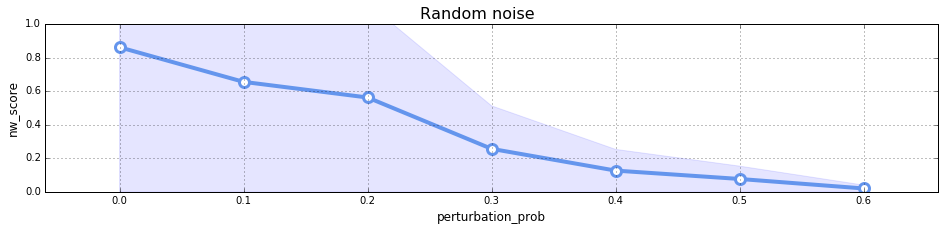

CPU times: user 8min 5s, sys: 41.8 s, total: 8min 47s
Wall time: 36min 41s


In [39]:
%%time
def make_results(n_rep=n_rep):
    for param in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
        avg_scores=[]
        for rep in range(n_rep):
            avg_score = make_experiment(complexity=5,
                                        motif_length=10,
                                        n_motives=3,
                                        sequence_length=50,
                                        n_sequences=6000,
                                        perturbation_prob=param,
                                        min_score=5,
                                        min_freq=0.65,
                                        min_cluster_size=10,
                                        n_clusters=10,
                                        min_subarray_size=5,
                                        max_subarray_size=15)
            avg_scores.append(avg_score)
        val = np.mean(avg_scores)
        std = np.std(avg_scores)
        yield param, val, std


data = [(param, val, std) for param, val, std in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='nw_score')

# Exp num sequences

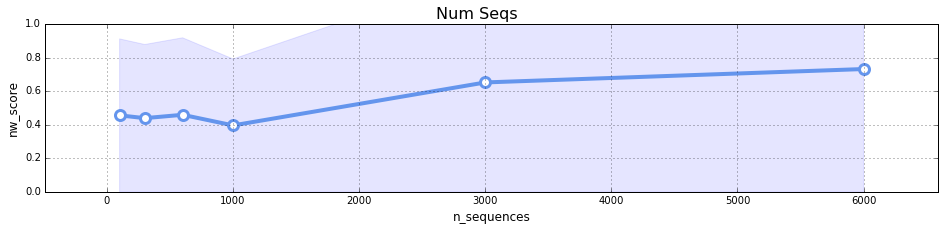

CPU times: user 57.3 s, sys: 16 s, total: 1min 13s
Wall time: 11min 32s


In [6]:
%%time
def make_results(n_rep=n_rep):
    for param in [100,300,600,1000,3000,6000]:
        avg_scores=[]
        for rep in range(n_rep):
            avg_score = make_experiment(complexity=5,
                                        motif_length=10,
                                        n_motives=3,
                                        sequence_length=50,
                                        n_sequences=param,
                                        perturbation_prob=.4,
                                        min_score=5,
                                        min_freq=0.65,
                                        min_cluster_size=10,
                                        n_clusters=20,
                                        min_subarray_size=5,
                                        max_subarray_size=15)
            avg_scores.append(avg_score)
        val = np.mean(avg_scores)
        std = np.std(avg_scores)
        yield param, val, std


data = [(param, val, std) for param, val, std in make_results()]
plot_results(data, title='Num Seqs', xlabel='n_sequences', ylabel='nw_score')

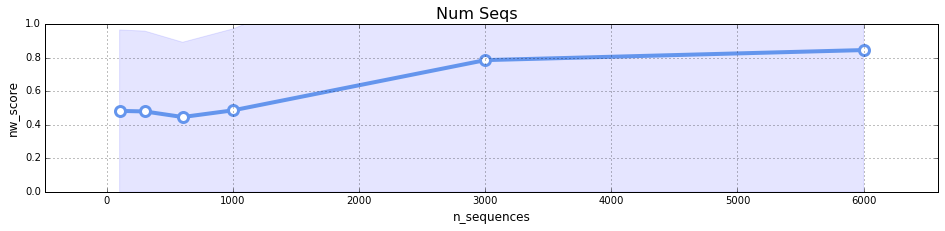

CPU times: user 53.7 s, sys: 16.2 s, total: 1min 9s
Wall time: 10min 9s


In [7]:
%%time
def make_results(n_rep=n_rep):
    for param in [100,300,600,1000,3000,6000]:
        avg_scores=[]
        for rep in range(n_rep):
            avg_score = make_experiment(complexity=5,
                                        motif_length=10,
                                        n_motives=3,
                                        sequence_length=50,
                                        n_sequences=param,
                                        perturbation_prob=.3,
                                        min_score=5,
                                        min_freq=0.65,
                                        min_cluster_size=10,
                                        n_clusters=20,
                                        min_subarray_size=5,
                                        max_subarray_size=15)
            avg_scores.append(avg_score)
        val = np.mean(avg_scores)
        std = np.std(avg_scores)
        yield param, val, std
        

data = [(param, val, std) for param, val, std in make_results()]
plot_results(data, title='Num Seqs', xlabel='n_sequences', ylabel='nw_score')

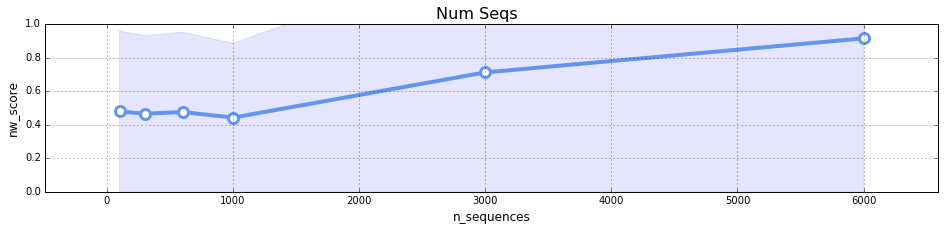

CPU times: user 54 s, sys: 19.4 s, total: 1min 13s
Wall time: 10min 27s


In [8]:
%%time
def make_results(n_rep=n_rep):
    for param in [100,300,600,1000,3000,6000]:
        avg_scores=[]
        for rep in range(n_rep):
            avg_score = make_experiment(complexity=5,
                                        motif_length=10,
                                        n_motives=3,
                                        sequence_length=50,
                                        n_sequences=param,
                                        perturbation_prob=.2,
                                        min_score=5,
                                        min_freq=0.65,
                                        min_cluster_size=10,
                                        n_clusters=20,
                                        min_subarray_size=5,
                                        max_subarray_size=15)
            avg_scores.append(avg_score)
        val = np.mean(avg_scores)
        std = np.std(avg_scores)
        yield param, val, std
        

data = [(param, val, std) for param, val, std in make_results()]
plot_results(data, title='Num Seqs', xlabel='n_sequences', ylabel='nw_score')

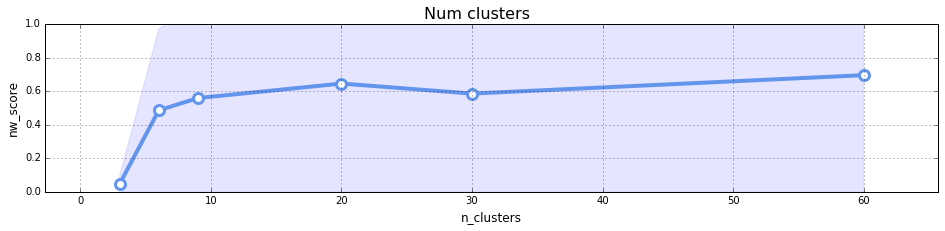

CPU times: user 1min 39s, sys: 30.4 s, total: 2min 10s
Wall time: 24min 11s


In [9]:
%%time
def make_results(n_rep=n_rep):
    for param in [3,6,9,20,30,60]:
        avg_scores=[]
        for rep in range(n_rep):
            avg_score = make_experiment(complexity=5,
                                        motif_length=10,
                                        n_motives=3,
                                        sequence_length=50,
                                        n_sequences=3000,
                                        perturbation_prob=.2,
                                        min_score=5,
                                        min_freq=0.65,
                                        min_cluster_size=10,
                                        n_clusters=param,
                                        min_subarray_size=5,
                                        max_subarray_size=15)
            avg_scores.append(avg_score)
        val = np.mean(avg_scores)
        std = np.std(avg_scores)
        yield param, val, std
        

data = [(param, val, std) for param, val, std in make_results()]
plot_results(data, title='Num clusters', xlabel='n_clusters', ylabel='nw_score')

In [ ]:
%%time
def make_results(n_rep=n_rep):
    for param in [1,2,3,4,5]:
        avg_scores=[]
        for rep in range(n_rep):
            avg_score = make_experiment(complexity=5,
                                        motif_length=10,
                                        n_motives=3,
                                        sequence_length=50,
                                        n_sequences=3000,
                                        perturbation_prob=.2,
                                        min_score=5,
                                        min_freq=0.65,
                                        min_cluster_size=10,
                                        n_clusters=20,
                                        min_subarray_size=6-param,
                                        max_subarray_size=10+param)
            avg_scores.append(avg_score)
        val = np.mean(avg_scores)
        std = np.std(avg_scores)
        yield param, val, std
        

data = [(param, val, std) for param, val, std in make_results()]
plot_results(data, title='Searched motif size', xlabel='range min=6-x max=10+x', ylabel='nw_score')

---